#### В задании Вам предлагается разобраться с тем, как работает TfidfVectorizer и DictVectorizer, затем обучить и настроить модель линейной регрессии Ridge на данных о публикациях на Хабрахабре. 

#### Описание соревнования

Предскажите, как много звездочек наберет статья, зная только ее текст и время публикации

Необходимо предсказать популярность поста на Хабре по содержанию и времени публикации. Как известно, пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать, что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import scipy

%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
train_df = pd.read_csv('../data/howpop_train.csv')
test_df = pd.read_csv('../data/howpop_test.csv')

In [4]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [5]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

Убедимся, что данные отсортированы по признаку published

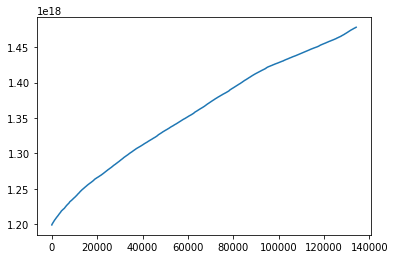

In [6]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot()

#### Чтобы ответить на вопросы 1 и 2, можно использовать pandas.DataFrame.corr(), pandas.to_datetime() и pandas.Series.value_counts()

**Вопрос 1. Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)**

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134137 entries, 0 to 134136
Data columns (total 17 columns):
url                 134137 non-null object
domain              134137 non-null object
post_id             134137 non-null int64
published           134137 non-null object
author              97657 non-null object
flow                97048 non-null object
polling             134137 non-null bool
content_len         134137 non-null int64
title               134137 non-null object
comments            134137 non-null int64
favs                134137 non-null int64
views               134137 non-null int64
votes_plus          133566 non-null float64
votes_minus         133566 non-null float64
views_lognorm       134137 non-null float64
favs_lognorm        134137 non-null float64
comments_lognorm    134137 non-null float64
dtypes: bool(1), float64(5), int64(5), object(6)
memory usage: 16.5+ MB


In [8]:
corr_matrix = train_df.corr()

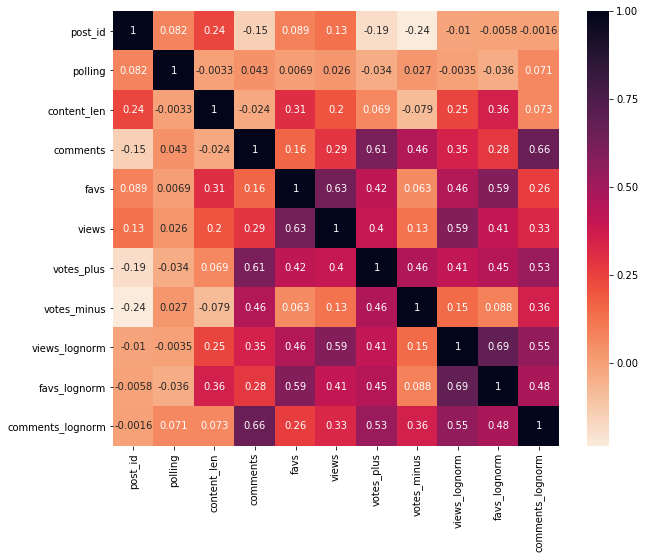

In [18]:
import seaborn as sns

cmap = sns.cm.rocket_r
sns.heatmap(corr_matrix, cmap=cmap, annot=True)
plt.rcParams['figure.figsize'] = [10, 8]

In [7]:
train_df['published'] = pd.to_datetime(train_df['published'])

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134137 entries, 0 to 134136
Data columns (total 17 columns):
url                 134137 non-null object
domain              134137 non-null object
post_id             134137 non-null int64
published           134137 non-null datetime64[ns]
author              97657 non-null object
flow                97048 non-null object
polling             134137 non-null bool
content_len         134137 non-null int64
title               134137 non-null object
comments            134137 non-null int64
favs                134137 non-null int64
views               134137 non-null int64
votes_plus          133566 non-null float64
votes_minus         133566 non-null float64
views_lognorm       134137 non-null float64
favs_lognorm        134137 non-null float64
comments_lognorm    134137 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(5), int64(5), object(5)
memory usage: 16.5+ MB


**Вопрос 2. В каком году было больше всего публикаций? (Рассматриваем train_df)**

In [29]:
train_df['published'].dt.year.value_counts()

2015    23452
2016    16316
2014    16180
2012    15972
2013    15537
2011    15063
2010    13091
2009    10783
2008     7743
Name: published, dtype: int64

### Разбиение на train/valid
Используем только признаки 'author', 'flow', 'domain' и 'title'

In [9]:
features = ['author', 'flow', 'domain', 'title']
train_size = int(0.7 * train_df.shape[0])

In [10]:
len(train_df), train_size

(134137, 93895)

In [11]:
X, y = train_df.loc[:, features], train_df['favs_lognorm']
X_test = test_df.loc[:, features]

In [12]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_valid = y.iloc[:train_size], y[train_size:]

### Применение TfidfVectorizer

TF-IDF (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции.

TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.

**Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

**Вопрос 3. Какой размер у полученного словаря?**

In [13]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1,3))

In [14]:
X_train_title = vectorizer_title.fit_transform(X_train['title'])

In [15]:
X_valid_title = vectorizer_title.transform(X_valid['title'])

In [16]:
X_test_title = vectorizer_title.transform(X_test['title'])

In [196]:
vectorizer_title.vocabulary_

{'новогодний': 31497,
 'подарок': 36257,
 'блоггерам': 14241,
 'wordpress': 12172,
 'новогодний подарок': 31499,
 'сумасшедшие': 45476,
 'яйца': 50489,
 'или': 22661,
 'сервис': 42745,
 'для': 18811,
 'отслеживания': 34225,
 'посетителей': 37373,
 'или сервис': 22833,
 'сервис для': 42751,
 'для отслеживания': 19413,
 'или сервис для': 22834,
 'сервис для отслеживания': 42753,
 'сглаживание': 42460,
 'шрифтов': 49862,
 'отрисовка': 34214,
 'сглаживание шрифтов': 42461,
 'почему': 37632,
 'мне': 28231,
 'не': 30755,
 'нравится': 31925,
 'iphone': 5951,
 'почему мне': 37659,
 'мне не': 28233,
 'не нравится': 30851,
 'всеобщая': 16456,
 'доступность': 20285,
 'действии': 18272,
 'чем': 49165,
 'суть': 45504,
 'проекта': 39310,
 'ru': 9541,
 'search': 9842,
 'запускается': 21584,
 'понедельник': 37201,
 'mobile': 7315,
 'выбор': 16759,
 'способа': 44575,
 'связи': 42437,
 'обзор': 32095,
 'под': 36147,
 'windows': 11973,
 'под windows': 36185,
 'онлайн': 33063,
 'банкинг': 13661,
 'оформле

In [197]:
# encode document
vector = vectorizer_title.transform(X_train['title'])

In [198]:
vector.shape

(93895, 50624)

**Вопрос 4. Какой индекс у слова 'python'?**

In [199]:
features = vectorizer_title.get_feature_names()

In [200]:
features.index('python')

9065

**Инициализируйте TfidfVectorizer, указав analyzer='char'.
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

**Вопрос 5. Какой размер у полученного словаря?**

In [17]:
vectorizer_ch = TfidfVectorizer(analyzer='char')

In [18]:
X_train_title_ch = vectorizer_ch.fit_transform(X_train['title'])

In [19]:
X_valid_title_ch = vectorizer_ch.transform(X_valid['title'])

In [20]:
X_test_title_ch = vectorizer_ch.transform(X_test['title'])

In [21]:
X_train_title_ch.shape

(93895, 218)

In [151]:
vectorizer_ch.vocabulary_

{' ': 0,
 '!': 1,
 '"': 2,
 '#': 3,
 '$': 4,
 '%': 5,
 '&': 6,
 "'": 7,
 '(': 8,
 ')': 9,
 '*': 10,
 '+': 11,
 ',': 12,
 '-': 13,
 '.': 14,
 '/': 15,
 '0': 16,
 '1': 17,
 '2': 18,
 '3': 19,
 '4': 20,
 '5': 21,
 '6': 22,
 '7': 23,
 '8': 24,
 '9': 25,
 ':': 26,
 ';': 27,
 '<': 28,
 '=': 29,
 '>': 30,
 '?': 31,
 '@': 32,
 '[': 33,
 '\\': 34,
 ']': 35,
 '^': 36,
 '_': 37,
 '`': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64,
 '{': 65,
 '|': 66,
 '}': 67,
 '~': 68,
 '\x92': 69,
 '\x97': 70,
 '\xa0': 71,
 '£': 72,
 '¥': 73,
 '§': 74,
 '©': 75,
 '«': 76,
 '\xad': 77,
 '®': 78,
 '°': 79,
 '±': 80,
 '²': 81,
 'µ': 82,
 '·': 83,
 '¹': 84,
 '»': 85,
 '¼': 86,
 '½': 87,
 '×': 88,
 'à': 89,
 'á': 90,
 'â': 91,
 'ä': 92,
 'ç': 93,
 'é': 94,
 'ë': 95,
 'ï': 96,
 'ñ': 97,
 'ò': 98,
 'ó': 9

### Работа с категориальными признаками


Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать DictVectorizer из sklearn.

In [24]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


Рассмотрим как он работает на примере первых пяти строк

In [161]:
# сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [166]:
# Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
# а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T

,0,1,2,3,4
author,@Tapac,@DezmASter,@DezmASter,@Taoorus,@dennydo
flow,develop,design,design,design,-
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru,habrahabr.ru,geektimes.ru


In [164]:
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 1: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 2: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 3: {'author': '@Taoorus', 'domain': 'habrahabr.ru', 'flow': 'design'},
 4: {'author': '@dennydo', 'domain': 'geektimes.ru', 'flow': '-'}}

In [167]:
# В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
# поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [168]:
# В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [169]:
# Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [170]:
# В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
# Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

Посмотрим, сколько уникальных значений в каждой колонке.
Суммарно их 9 - столько же, сколько и колонок. Это объясняется тем, что для категориальных признаков со строковыми значениями DictVectorizer делает кодирование бинарными признаками - каждому уникальному значению признака соответствует один новый бинарный признак, который равен 1 только в том случае, если в исходной матрице этот признак принимает значение, которому соответствует эта колонка новой матрицы.

In [173]:
for col in feats:
    print(col, len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


Также можно посмотреть, что означает каждая колонка полученной матрицы

In [174]:
# например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

**Инициализируйте DictVectorizer с параметрами по умолчанию.**


**Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

In [25]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train[feats].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid[feats].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test[feats].fillna('-').T.to_dict().values())

In [26]:
X_train_feats.shape

(93895, 17869)

Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [27]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new = scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

### Обучение модели

Далее будем использовать Ridge, линейную модель с l2-регуляризацией.

Основной параметр Ridge - **alpha, коэффициент регуляризации**. Регуляризация используется для улучшения обобщающей способности модели - прибавляя к функционалу потерь сумму квадратов весов, умноженную на коэффициент регуляризации (та самая alpha), мы штрафуем модель за слишком большие значения весов и не позволяем ей переобучаться. Чем больше этот коээфициент, тем сильнее эффект.

**Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1**

**Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.**

In [204]:
%%time
model1 = Ridge(alpha=0.1, random_state=1)
model1.fit(X_train_new, y_train)

CPU times: user 9.16 s, sys: 39.4 ms, total: 9.2 s
Wall time: 9.21 s


In [205]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('Ошибка на трейне', mean_squared_error(y_train, train_preds1))
print('Ошибка на тесте', mean_squared_error(y_valid, valid_preds1))

Ошибка на трейне 0.18410703158183817
Ошибка на тесте 0.9026475546335921


In [207]:
%%time
model2 = Ridge(alpha=1.0, random_state=1)
model2.fit(X_train_new, y_train)

CPU times: user 4.26 s, sys: 29.8 ms, total: 4.29 s
Wall time: 4.3 s


In [208]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('Ошибка на трейне', mean_squared_error(y_train, train_preds2))
print('Ошибка на тесте', mean_squared_error(y_valid, valid_preds2))

Ошибка на трейне 0.2862440747098309
Ошибка на тесте 0.7011446274342489


**Вопрос 6. Выберите верные утверждения:**

- обе модели показывают одинаковый результат (среднеквадратичная ошибка отличается не больше чем на тысячные), регуляризация ничего не меняет
- при alpha=0.1 модель переобучается
- среднеквадратичная ошибка первой модели на тесте меньше
- при alpha=1.0 у модели обощающая способность лучше, чем у при alpha=0.1

### Baseline

**Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.**

In [28]:
%%time
model = Ridge()
model.fit(scipy.sparse.vstack([X_train_new, X_valid_new]), y)
test_preds = model.predict(X_test_new)

CPU times: user 6.51 s, sys: 76.8 ms, total: 6.59 s
Wall time: 6.59 s


In [29]:
sample_submission = pd.read_csv('../data/habr_sample_submission.csv', index_col='url')

In [30]:
sample_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754


In [31]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds
# это будет бейзлайн "Простое решение"
ridge_submission.to_csv('ridge_submission.csv')